## 1. Autoencoder
*     Reference. https://dacon.io/codeshare/4551
*     FashionMNIST dataset

(1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [ ]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [ ]:
trainset = datasets.FashionMNIST(
    root      = './data',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [ ]:
#Autoencoder 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [ ]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
# 복원이 어떻게 되는지 관찰하기 위해 5개의 이미지 가져와 넣어보기
view_data = view_data.type(torch.FloatTensor)/255.

In [ ]:
#학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x,label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) #x(입력)와 y(label) 모두 원본이미지(x)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


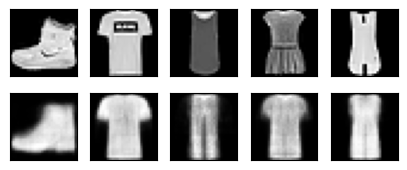

[Epoch 2]


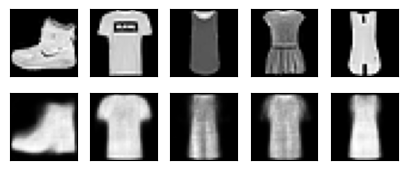

[Epoch 3]


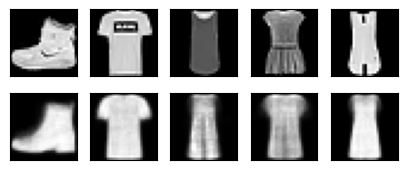

[Epoch 4]


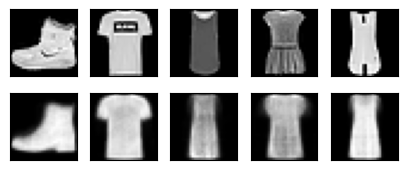

[Epoch 5]


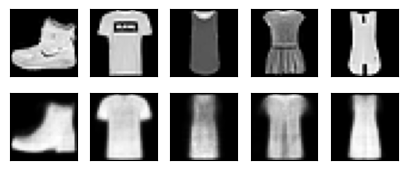

[Epoch 6]


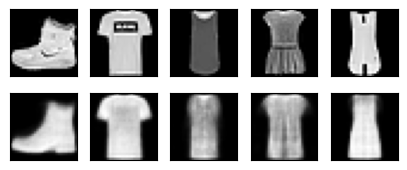

[Epoch 7]


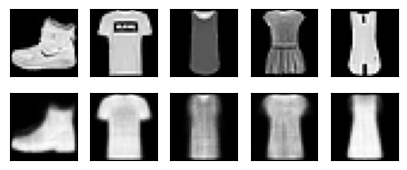

[Epoch 8]


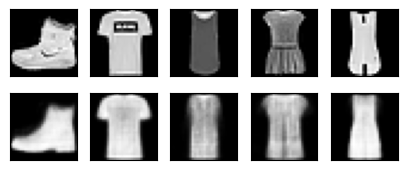

[Epoch 9]


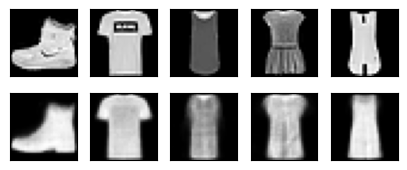

[Epoch 10]


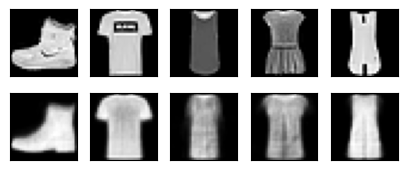

In [ ]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    #원본과 디코딩 결과 비교
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#### (2) Image Denoising w/ AE

In [ ]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    #random noise를 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만
    #noise의 강도 0.2
    noisy_img = img + noise
    return noisy_img

In [ ]:
#학습코드에 노이즈 더하기 코드 한 줄 추가
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x,label) in enumerate(train_loader):
        noisy_x = add_noise(x) #입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() #평균 오찻값 관
    return avg_loss / len(train_loader)

In [ ]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.02246678923008475
[Epoch 2] loss:0.02214456072001696
[Epoch 3] loss:0.022063621151040613
[Epoch 4] loss:0.021975545180854258
[Epoch 5] loss:0.021878586823879276
[Epoch 6] loss:0.02191549333443901
[Epoch 7] loss:0.021798806179608745
[Epoch 8] loss:0.021707562374264827
[Epoch 9] loss:0.021654079648366235
[Epoch 10] loss:0.021690635316407504


In [ ]:
# 잡음제거 시각화
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옴
testset = datasets.FashionMNIST(
    root      = './data',
    train     = False, #Unseen test dataset
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져옴
sample_data = testset.data[0].view(-1, 28*28) #1차원 행렬로 변환
sample_data = sample_data.type(torch.FloatTensor)/255

# 이미지를 add_noise로 noise 넣어주고 모델에 통과시킴
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

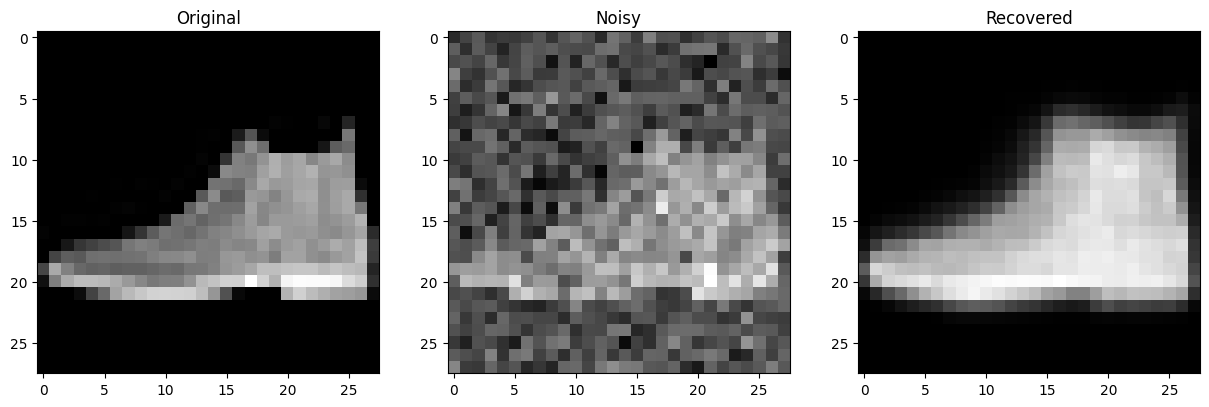

In [ ]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) # 1행 3열의 표

# 시각화를 위해 넘파이 행렬로 변환
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# original imge w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recovered image
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()


Question 1. Explain the code of the '1. Autoencoder' section "briefly".

## 2. Principal Component Analysis [PCA]
*    Reference. https://romg2.github.io/mlguide/12_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-06.-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C-PCA/

### Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

PCA(Principal Component Ananlysis)는 대표적인 dimensionality reduction(차원축소)에 쓰이는 기법이다.

고차원의 데이터를 낮은 차원의 데이터로 바꿔주는 것인데, 이 과정에서 최대한 고차원의 특징을 살리며 차원을 낮춰주는 방법 중 하나가 PCA이다.

여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표하는 주성분(Principal Component)를 추출해 차원을 축소한다. PCA는 가장 높은 분산을 가지는 데이터의 축을 찾아 이 축으로 차원을 축소하는데 이것이 PCA의 주성분이 된다.

#### PCA알고리즘
1. N차원 데이터의 covariance matrix를 생성한다
2. 생성한 covariance matrix에서 N개의 Eigenstuff(Eigenvector, Eigenvalue)를 찾는다.
3. 구한 Eigenstuff를 Eigenvalue가 큰 순서대로 정렬한다.
4. 원하는 만큼 Eigenvector를 쳐냄으로써 차원 축소를 해준다.
5. 남은 Eigenvector를 축으로 하여, 데이터의 차원을 줄인다.

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [13]:
%matplotlib inline
%config lnlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

#차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [10]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


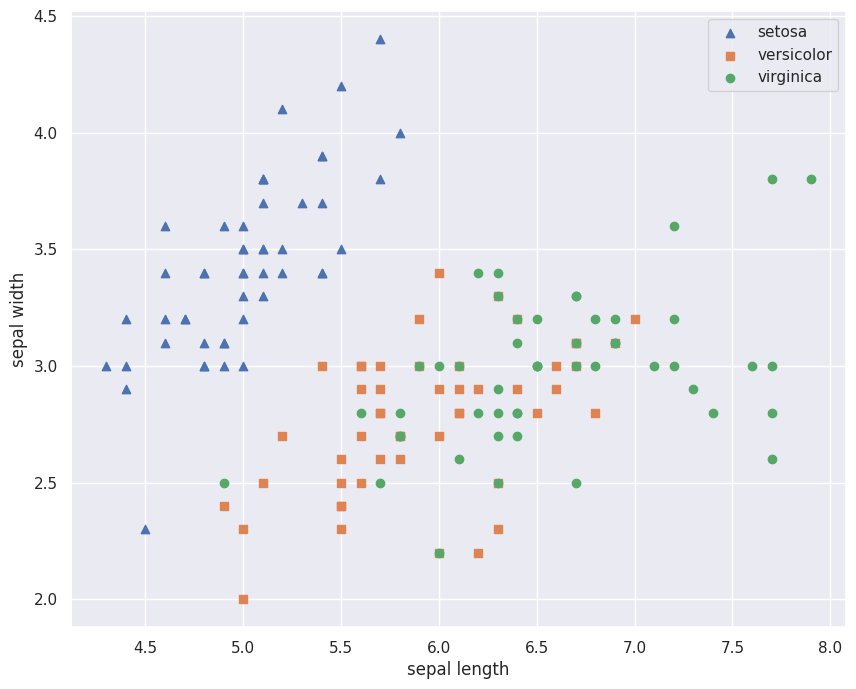

In [14]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

warnings.filterwarnings("ignore")

일부 피처에 대해 붓꽃 종류를 시각화

setosa의 경우 sepal width가 3이상, sepal lenth가 6이하인 곳에 대부분 분포

vewsicolor, virginica는 sepal width, sepal length만으로는 분류가 어려움

In [18]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:, :-1])
# PCA는 여러 피처 값 연산하기에 스케일에 영향을 받으므로 적용 전에 피처 스케일링 작업이 필요
#StandardScaler()로 표준정규분포로 변환

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

# 스케일 데이터 -> PCA 변환 데이
pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [22]:
# PCA 데이터 프레임 생성
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns=pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


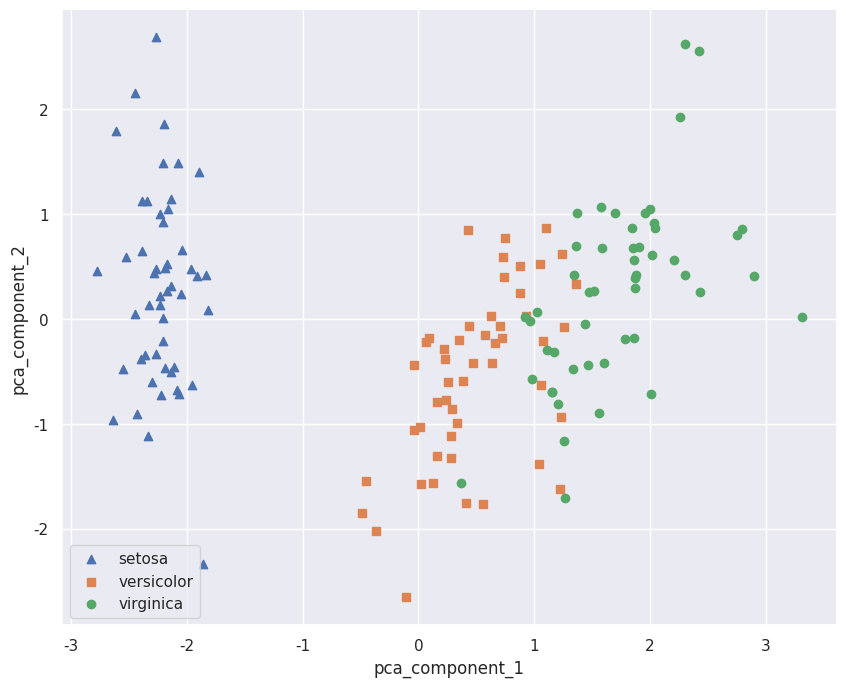

In [23]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

PCA 변환 후 2개 피처로 붓꽃 종류 시각화

versicolor, virginica는 pca_component_1 축을 기반으로 일부 겹치긴 하지만 비교적 잘 구분됨

이는 pca_component_1이 원본 데이터의 변동성을 잘 반영하였기 때문

In [24]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data

[0.72962445 0.22850762]


PCA를 2개 요소로만 변환해도 원본 데이터의 변동성의 약 95%를 설명할 수 있

### Question 3.
### Autoencoder reduces the dimension of the data w/ deep learning methods.
### PCA does the same thing in mathematically linear way.
### In this context, Autoencoder is a **nonlinear** PCA.

## 4. Seq2Seq, Attention, Transformer

### Question 4 (Optional).
### Choose one of the following document. Read it, run the whole code and write and explanation.
### (1) Machine Translation using Attention and Seq2Seq: https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html
### (2) Understanding Transformer: https://wikidocs.net/156986
### (3) Chatbot based on Text Similarity (Transformer): https://wikidocs.net/157970

#(1) Machine Translation using Attention and Seq2Seq:

 https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

In [26]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!unzip -qq /content/drive/MyDrive/fra-eng.zip -d /content/drive/MyDrive/

* 언어의 각 단어들을 One-Hot 벡터로 표현하기 때문에 인코딩 벡터가 매우 큼

-> 약간의 트릭으로 언어 당 수천 단어 만 사용하도록 데이터를 다듬을 것

* 나중에 네트워크의 input 및 output으로 사용하려면 단어 당 고유 번호가 필요

이것들을 추적하기 위해 Lang이라는 헬퍼 클래스를 사용

* Lang에는 word2index 사전, index2word 사전, word2count (나중에 희귀단어를 대체하는데 사용할 각 단어의 빈도)가 있음

In [33]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [37]:
# 유니 코드 문자열을 일반 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) # 소문자 변환, 양쪽의 공백 제거
    s = re.sub(r"([.!?])", r" \1", s)  # '.', '!', '?' 앞에 공백 추가 #문장 구분을 쉽게 하기위함
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # 알파벳과 문장부호를 제외한 모든 문자를 공백으로 대
    return s.strip()

In [67]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    #파일을 읽고 줄로 분리
    lines = open('drive/MyDrive/fra.txt', encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    else:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)

    return input_lang, output_lang, pairs

In [71]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [72]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 163475 sentence pairs
Counting words...
Counted words:
eng 1846
fra 20512
['cc by . france attribution tatoeba .org ck hortusdei', 'il a travaille toute la journee d hier .', 'he worked all day yesterday .']


data 다운이 잘 안 되는 것 같아서 ㅜ
transformer를 다른 파일에 시도해보겠습니다